In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.callback import EarlyStopping

# Configuração fos gráficos

In [37]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Carregando os DF

In [44]:
df = pd.read_csv('../DF/dados_tratados_ana_carnaubal_completo2.csv', sep=';', encoding='utf-8-sig')
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.sort_values(by='data').reset_index(drop=True)

# Criando as Features com "memória" (LAGS)

In [51]:
features_clima = ['TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)','PRECIPITACAO TOTAL, HORARIO(mm)','RADIACAO GLOBAL(Kj/m²)','UMIDADE RELATIVA DO AR, HORARIA(%)','VENTO, VELOCIDADE HORARIA(m/s)'] 

for feature in features_clima:
    for lag in range(1, 4):
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)


In [65]:
df_sc = df[df['PRECIPITACAO TOTAL, HORARIO(mm)'] == 0].copy()
df_sc.dropna(inplace=True)
df_sc['perda_agua_m3'] = (df_sc['variacao_volume']*-1)*1000000

# Treinamento do modelo XGBoost

In [72]:
x = df_sc.drop(columns=['data','volume','variacao_volume','perda_agua_m3','PRECIPITACAO TOTAL, HORARIO(mm)'])
y = df_sc['perda_agua_m3']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model_xgboost = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=1500,
                                 learning_rate=0.05,
                                 early_stopping_rounds=50,
                                 n_jobs=-1,
                                 random_state=42)

In [73]:
parada_ante = EarlyStopping(rounds=50, save_best=True)
model_xgboost.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
previsao = model_xgboost.predict(x_test)
r2 = r2_score(y_test, previsao)
mae = mean_absolute_error(y_test, previsao)

In [74]:
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f}')


R²: -0.0144
MAE: 8185.9413


# Análise de importâncias com as features

In [75]:
importancias = model_xgboost.feature_importances_
features = x.columns
features_importacia_df = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by='Importancia', ascending=False)

In [76]:
print("Top 10 features mais importantes:")
print(features_importacia_df.head(10))

Top 10 features mais importantes:
                                              Feature  Importancia
3                  UMIDADE RELATIVA DO AR, HORARIA(%)     0.651168
0                                        Hora Medicao     0.150392
4                      VENTO, VELOCIDADE HORARIA(m/s)     0.032027
2         TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)     0.031341
11                       RADIACAO GLOBAL(Kj/m²)_lag_1     0.019086
7   TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_lag_3     0.016496
5   TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_lag_1     0.015285
12                       RADIACAO GLOBAL(Kj/m²)_lag_2     0.012466
1                              RADIACAO GLOBAL(Kj/m²)     0.011865
19               VENTO, VELOCIDADE HORARIA(m/s)_lag_3     0.010858


# Plotando gráficos de importância

C:\Users\marco\AppData\Local\Temp\ipykernel_15692\2151228134.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=features_importacia_df.head(10), palette='viridis')


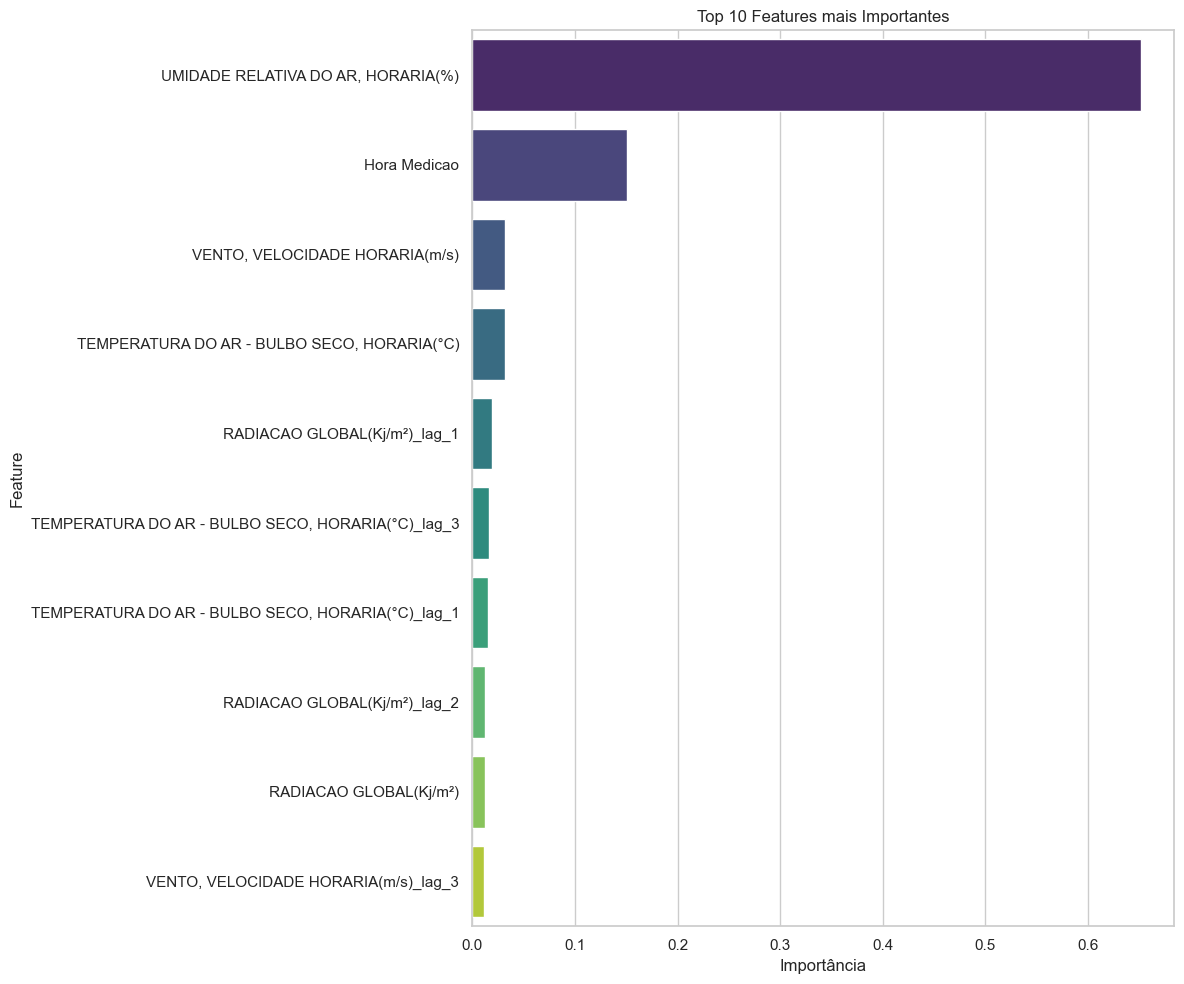

In [78]:
plt.figure(figsize=(12, 10))
sns.barplot(x='Importancia', y='Feature', data=features_importacia_df.head(10), palette='viridis')
plt.title('Top 10 Features mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()